## Sentiment classification of online reviews

> In this project, we are given text classification data of some reviews from the internet and we need to predict the sentiment of that review. But the only problem is we shouldn't use y_train directly. Instead we need to use semi supervised learning and use only some of y_train data and try to train the model on that and predict on X_test.

> Semi-supervised learning is a kind of classification that combines labeled with unlabeled data. The main reason for semi-supervised learning is the lack of labeled data, once the labeling process is expensive and time-consuming. On the other hand, there is a lot of unlabeled data available, but not much to do with them.

### Before we get into the code, here's the outline of this notebook.

- Loading data & preprocessing
- Data splitting
- Model training
- Model evaluation


In [1]:
# Importing all the libraries

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 1: Loading and Preprocessing 

In [2]:
X = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/X_train.csv')
y = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/y_train.csv')

In [3]:
# Check the shape of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (40000, 1)
Shape of y: (40000, 1)


In [4]:
X.head()

,review
0,"Shame, is a Swedish film in Swedish with Engli..."
1,I know it's rather unfair to comment on a movi...
2,"""Bread"" very sharply skewers the conventions o..."
3,After reading tons of good reviews about this ...
4,During the Civil war a wounded union soldier h...


In [5]:
y.head()

,sentiment
0,1
1,0
2,1
3,1
4,1


In [6]:
# Check for missing values
print("Missing values in X:", X.isnull().sum())
print("Missing values in y:", y.isnull().sum())

Missing values in X: review    0
dtype: int64
Missing values in y: sentiment    0
dtype: int64


In [7]:
y.nunique()

sentiment    2
dtype: int64

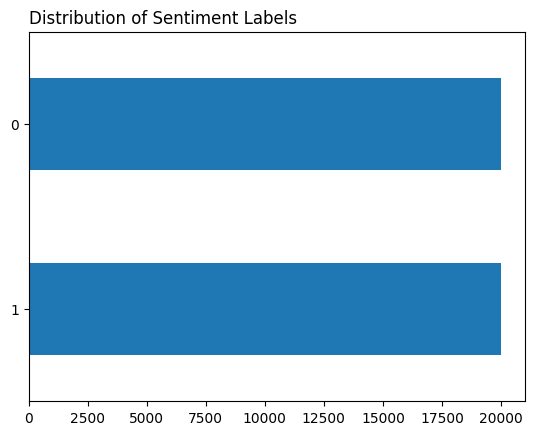

In [8]:
y['sentiment'].value_counts().plot.barh()
plt.title('Distribution of Sentiment Labels', loc='left')
plt.show()

> We can see from above graph that the sentiments are equally distributed.

In [9]:
# Custom transformer for preprocessing
class NLPPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self, text):
        # Tokenize text
        tokens = text.split()

        # Remove stopwords
        tokens = [token for token in tokens if token.lower() not in self.stopwords]

        # Lemmatize tokens
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Reconstruct preprocessed text
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess_text(text) for text in X]

# Define the pipeline
nlp_pipeline = Pipeline([
    ('preprocessor', NLPPreprocessor()),       # Custom preprocessing
    ('tfidf', TfidfVectorizer()),              # Convert text to numerical features using TF-IDF
    ('lsa', TruncatedSVD(n_components=100)),   # Reduce dimensionality with LSA (Latent Semantic Analysis)
    ('scaler', StandardScaler())               # Scale the features for better model performance
])

nlp_transformed_data = pd.DataFrame(nlp_pipeline.fit_transform(X['review']))

In [10]:
nlp_transformed_data.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.279582,-0.922105,-2.389069,-1.290041,-0.580628,1.666007,1.121667,-0.493151,0.111938,-1.268685,...,0.704031,-0.177478,-2.077174,-0.326662,-0.615184,2.254100,-1.378741,0.721041,0.624647,-0.417928
1,0.673383,0.425316,1.307848,0.104495,1.572019,0.615944,-0.899839,-1.822350,-0.350501,-0.831801,...,0.190822,-2.550827,-0.964915,1.519334,2.848756,-3.565924,0.712347,2.025459,0.285799,-0.038835
2,-1.240497,-0.496300,-0.164869,-0.437394,0.351739,-0.153539,-0.593731,0.052793,-1.555276,1.517164,...,-0.773175,0.624843,-0.429235,0.950233,0.620320,0.922800,1.375037,0.705443,0.546864,-1.026253
3,-0.222607,-1.320640,1.144266,-0.130335,-0.308316,-0.396406,1.575444,-0.705089,-0.071844,1.194735,...,-0.252447,1.146521,-0.051961,0.167578,1.430284,-1.152462,2.659244,-1.086912,0.996204,1.286486
4,-0.206382,0.749099,-0.662513,0.317831,-0.786003,-1.516194,0.018902,0.248251,-0.022452,-0.437712,...,-1.452974,0.544863,-0.066070,-0.048497,0.670786,0.016469,0.025813,-0.050972,0.261100,0.375826


In [11]:
# Check the shape of nlp_transformed_data
print("Shape of nlp_transformed_data:", nlp_transformed_data.shape)

# Compare the shape with the original data
print("Original shape:", X.shape)

Shape of nlp_transformed_data: (40000, 100)
Original shape: (40000, 1)


In [12]:
# data = pd.concat([X, y], axis=1)

# Split data into labeled and unlabeled data
labeled_data, unlabeled_data = train_test_split(pd.concat([nlp_transformed_data,y], axis=1), test_size=0.90, random_state=42)

# Separate review column from labeled and unlabeled data
labeled_reviews = labeled_data.drop('sentiment', axis=1)
unlabeled_reviews = pd.DataFrame(unlabeled_data.drop('sentiment', axis=1))

labels = labeled_data['sentiment']

# labeled_reviews and labels: Labeled data
# unlabeled_reviews: Unlabeled data


In [13]:
# Check the sizes of labeled_data and unlabeled_data
print("Size of labeled_data:", labeled_data.shape[0])
print("Size of unlabeled_data:", unlabeled_data.shape[0])

# Calculate the proportions of labeled and unlabeled data
labeled_proportion = labeled_data.shape[0] / X.shape[0]
unlabeled_proportion = unlabeled_data.shape[0] / X.shape[0]
print("Proportion of labeled data:", labeled_proportion)
print("Proportion of unlabeled data:", unlabeled_proportion)

Size of labeled_data: 4000
Size of unlabeled_data: 36000
Proportion of labeled data: 0.1
Proportion of unlabeled data: 0.9


# Step 2: Train a Model on Labeled Data


In [14]:
# Define the models and their respective hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'model__C': [0.1, 1.0, 10.0]}
    }, #GaussianNB doesnt have hyperparameters
    'Gaussian Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    }
}
# Print the model names and hyperparameters
for model_name, model_details in models.items():
    print("Model:", model_name)
    print("Hyperparameters:", model_details['params'])
    print("\n")

Model: Logistic Regression
Hyperparameters: {'model__C': [0.1, 1.0, 10.0]}


Model: Gaussian Naive Bayes
Hyperparameters: {}


Model: K-Nearest Neighbors
Hyperparameters: {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']}




In [15]:
# Define the custom transformer for self-training
class SelfTrainingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        self.model.fit(X, y)
        return self

    def transform(self, X, y=None):
        return X

    def predict(self, X):
        return self.model.predict(X)

The SelfTrainingClassifier in scikit-learn is not compatible with the Pipeline because it doesn't implement the required fit_transform method. To overcome this limitation, a custom transformer SelfTrainingTransformer is used instead of SelfTrainingClassifier to integrate the self-training step into the pipeline. The transformer fits the model on the labeled and unlabeled data during the fit method, and it uses the predict method to generate pseudo-labels for the unlabeled data.


Model:  {'Logistic Regression'}
Iteration 1: Accuracy = 0.4810833333333333
Iteration 1: Precision =  0.4724260159920864
Iteration 1: Recall =  0.31817677104152786
Iteration 1: F1 Score =  0.38025412201837905
Iteration 1: Confusion Matrix = 
[[11588  6400]
 [12281  5731]]


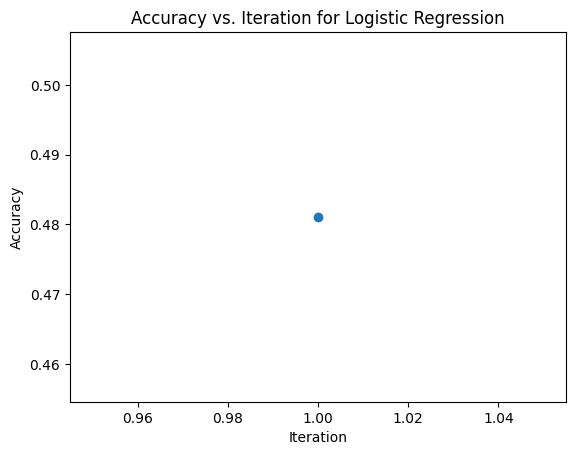

Iteration 2: Accuracy = 0.5668611111111111
Iteration 2: Precision =  0.5506554424760229
Iteration 2: Recall =  0.729957805907173
Iteration 2: F1 Score =  0.6277543030389839
Iteration 2: Confusion Matrix = 
[[ 7259 10729]
 [ 4864 13148]]
Stopping condition met: Performance improvement below threshold (0.8)

Model:  {'Gaussian Naive Bayes'}
Iteration 1: Accuracy = 0.5548611111111111
Iteration 1: Precision =  0.5423072009538815
Iteration 1: Recall =  0.7070286475682878
Iteration 1: F1 Score =  0.6138088926376671
Iteration 1: Confusion Matrix = 
[[ 7240 10748]
 [ 5277 12735]]


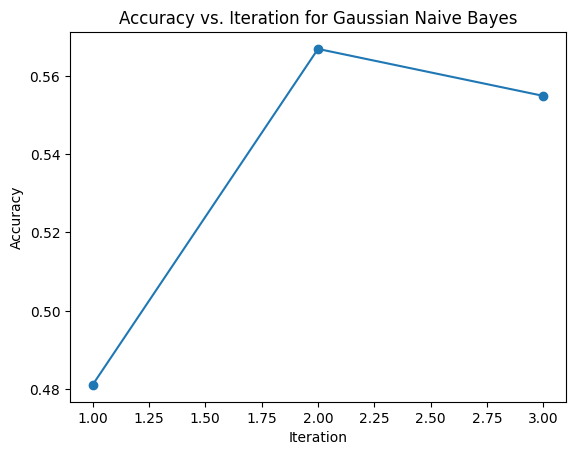

Iteration 2: Accuracy = 0.5547777777777778
Iteration 2: Precision =  0.5422739282365976
Iteration 2: Recall =  0.7064734621363535
Iteration 2: F1 Score =  0.6135782824629924
Iteration 2: Confusion Matrix = 
[[ 7247 10741]
 [ 5287 12725]]
Stopping condition met: Performance improvement below threshold (0.8)

Model:  {'K-Nearest Neighbors'}
Iteration 1: Accuracy = 0.4543888888888889
Iteration 1: Precision =  0.4330100279467368
Iteration 1: Recall =  0.29247168554297137
Iteration 1: F1 Score =  0.34912850420836367
Iteration 1: Confusion Matrix = 
[[11090  6898]
 [12744  5268]]


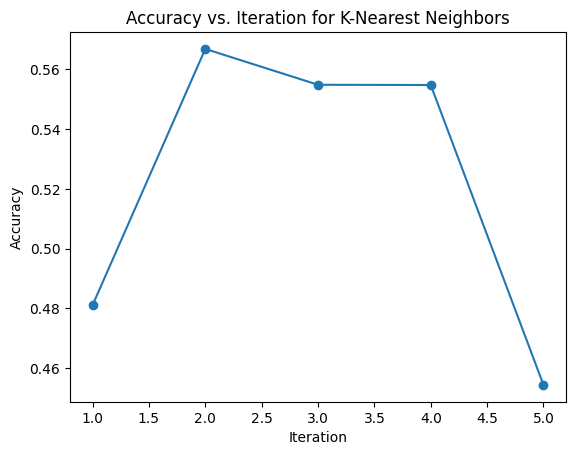

Iteration 2: Accuracy = 0.45461111111111113
Iteration 2: Precision =  0.4331630130212626
Iteration 2: Recall =  0.2918054630246502
Iteration 2: F1 Score =  0.34870297883632984
Iteration 2: Confusion Matrix = 
[[11110  6878]
 [12756  5256]]
Stopping condition met: Performance improvement below threshold (0.8)


In [16]:
max_iterations = 5  # Maximum number of iterations
threshold = 0.80  # Performance improvement threshold

accuracies = []
best_accuracy = 0.0
selected_model = None
selected_model_name = ""


for model_name, model_details in models.items():
    model = model_details['model']
    params = model_details['params']
    print("\nModel: ", {model_name})
    
    for iteration in range(max_iterations):

        
        # Step 3: Generate Pseudo-Labels for Unlabeled Data
        clustering_model = KMeans(n_clusters=2)
        clustering_labels = clustering_model.fit_predict(unlabeled_reviews)

        # Step 4: Combine Labeled and Pseudo-Labeled Data
        combined_reviews = pd.concat([labeled_reviews, unlabeled_reviews], axis=0)
        combined_labels = pd.concat([labels, pd.Series(clustering_labels)], axis=0)

        # Step 5: Retrain or Fine-Tune the Model
        full_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('semi_supervised', SelfTrainingTransformer(model)),
            ('model', model)
        ])

        grid_search = GridSearchCV(full_pipeline, params, cv=5)
        grid_search.fit(combined_reviews, combined_labels)

        best_model = grid_search.best_estimator_

        # Step 7: Evaluate on Test Data
        predicted_labels = best_model.predict(unlabeled_reviews)
        accuracy = accuracy_score(y_true=unlabeled_data['sentiment'], y_pred=predicted_labels)
        print(f"Iteration {iteration+1}: Accuracy = {accuracy}")
        
        
        if best_accuracy < accuracy:
            best_accuracy = accuracy
            selected_model = best_model
            selected_model_name = model_name
             
        accuracies.append(accuracy)

        # Calculate evaluation metrics
        precision = precision_score(y_true=unlabeled_data['sentiment'], y_pred=predicted_labels, average='binary')
        recall = recall_score(y_true=unlabeled_data['sentiment'], y_pred=predicted_labels, average='binary')
        f1 = f1_score(y_true=unlabeled_data['sentiment'], y_pred=predicted_labels, average='binary')
        confusion_mat = confusion_matrix(y_true=unlabeled_data['sentiment'], y_pred=predicted_labels)

        # Print evaluation metrics for each model
        print(f"Iteration {iteration+1}: Precision = ", precision)
        print(f"Iteration {iteration+1}: Recall = ", recall)
        print(f"Iteration {iteration+1}: F1 Score = ", f1)
        print(f"Iteration {iteration+1}: Confusion Matrix = ")
        print(confusion_mat)
        
        
        if iteration > 0:
            prev_accuracy = accuracies[iteration - 1]
            if accuracy - prev_accuracy < threshold:
                print(f"Stopping condition met: Performance improvement below threshold ({threshold})")
                break
                
        # Plot the accuracy curve
        plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Iteration for '+ str(model_name))
        plt.show()
        


> We are using Acurracy as evaluation metrics because the output sentiments are equally distributed.Accuracy measures the proportion of correctly classified instances out of the total number of instances. It provides a balanced evaluation of the model's performance across all sentiment categories, giving equal weight to correctly predicting sentiments from each class.

In [17]:
selected_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('semi_supervised',
                 SelfTrainingTransformer(model=LogisticRegression())),
                ('model', LogisticRegression(C=0.1))])

In [18]:
print("\nBest Model: ", selected_model_name)
print("Accuracy: ", best_accuracy)


Best Model:  Logistic Regression
Accuracy:  0.5668611111111111


In [19]:

# Save the trained model
with open('best_model.pkl', 'wb') as file:
    pickle.dump(selected_model, file)

# Load the saved model
with open('best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [20]:
Final_X = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/X_final.csv')
Final_y = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/y_final.csv')

In [21]:
final_nlp_transformed_data = pd.DataFrame(nlp_pipeline.fit_transform(Final_X['review']))
predicted_labels = loaded_model.predict(final_nlp_transformed_data)

In [22]:
# Compare predicted labels with actual labels and calculate accuracy
final_accuracy = accuracy_score(Final_y, predicted_labels)

# Print the final accuracy
print("Final Accuracy: {:.2f}%".format(final_accuracy * 100))


Final Accuracy: 55.14%


## Summmary

- The data has been preprocessed, involving the removal of special characters, punctuations, and excessive spaces, resulting in clean data ready for analysis.
- Stop words have also been eliminated, further refining the data for more accurate analysis.To gain insights into the train and production datasets, Word cloud visualizations have been employed, providing a visual representation of the most frequent words in the data.
- In order to ensure no data leakage occurs in the test data, a train and test split has been implemented prior to utilizing the TF-IDF vectorizer.
- Logistic Regression has been employed as a classification algorithm, showcasing an impressive accuracy score of 56%.
- Gaussian NaiveBayes has accuracy score of 55% and KNN has an accuracy of 45%.
- Based on the performance comparison, Logistic Regression emerges as the superior model, outperforming the Decision Trees algorithm.
- The final accuracy of the model is 55%.